In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp
from scipy.optimize import root
from matplotlib import pyplot as plt
import time
import mesa_reader as mr

import constants as c

In [2]:
# defining initial values/guesses

X = 0.7
Z = 0.02
Y = 1 - X - Z

mu = 4 / (3 + 5 * X) # fully ionized

M_star = 1.33*c.Ms
L_star = ((M_star/c.Ms)**(3.5))*c.Ls # eq. 1.88 HKT
R_star = ((M_star/c.Ms)**(0.75))*c.Rs # eq. 1.87 HKT
Pc_star = 1.92e17 # solar central pressure
Tc_star = 1.57e7 # solar central temp

In [3]:
# importing opacity table

highT_dir = '/Users/jaredbull/Documents/notebooks/class/stellar/GN93hz_73.txt'

df = pd.read_csv(highT_dir, sep="\\s+", skiprows=4, index_col=0)
df.columns = df.columns.astype(float)
df.index = df.index.astype(float)

log_T = df.index.to_numpy()
log_R = df.columns.to_numpy()
log_opacities = df.to_numpy()

In [4]:
interpolator = RegularGridInterpolator((log_T, log_R), log_opacities)

In [5]:
# defining opacity table interpolation function

def interpolated_opacity(rho, T): 
        
    R = rho / (T * 10**-6)**3
    
    R = np.maximum(R, 10**-8)
    log_R = np.log10(R)
    
    T = np.maximum(T, 10**3.75)
    log_T = np.log10(T)
    
    point = [log_T, log_R]
    
    log_interpolated_value = interpolator(point)[0]
        
    opacity = 10**log_interpolated_value
    return opacity

In [6]:
# functions for energy output calculation

def g11(T): 
    T9 = 1e-9 * T
    return 1 + 3.82 * T9 + 1.51 * T9**2 + 0.144 * T9**3 - 0.0114 * T9**4

def eps_pp(rho, T): 
    T7 = 1e-7 * T
    T9 = 1e-9 * T
    psi = 1
    f11 = np.exp(5.92e-3 * rho**0.5 / T**1.5)
    return 2.57 * 10**4 * psi * f11 * g11(T9) * rho * X**2 * (T9)**(-2/3) * np.exp(-3.381 / T9**(1/3))

def g141(T): 
    T9 = 1e-9 * T
    return 1 - 2.00 * T9 + 3.41 * T9**2 - 2.43 * T9**3

def eps_CNO(rho, T):
    T9 = 1e-9 * T
    X_CNO = (2/3)*Z
    return 8.24 * 10**25 * g141(T) * X_CNO * X * rho * T9**(-2/3) * np.exp(-15.231 * T9**(-1/3)-(T9/0.8)**2)

def eps(rho, T): 
    return eps_pp(rho, T) + eps_CNO(rho, T)

In [7]:
# function for calculating density

def rho(P, T): 
    return (P - c.a*T**4 / 3) * mu / (c.N_A * c.k * T)

In [14]:
def inner(M_r, P_c, T_c):
    
    """Defines stellar center boundary conditions, approximate values to avoid singularities."""
    
    rho_c = rho(P_c, T_c)
    r = (3 * M_r / (4 * np.pi * rho_c))**(1/3)
    
    eps_var = eps(rho_c, T_c)
    l_r = eps_var * M_r
    
    P_r = P_c - 3 * c.G / (8 * np.pi) * (4 * np.pi / 3 * rho_c)**(4/3) * M_r**(2/3)
    T_r = (T_c**4 - 1 / (2 * c.a * c.c) * (3 / (4 * np.pi))**(2/3) * interpolated_opacity(rho_c, T_c) * eps_var * rho_c**(4/3) * M_r**(2/3))**(1/4) # for radiative core
    
    return (r, l_r, P_r, T_r)

def outer(R, L):

    """Defines stellar envelope boundary conditions."""
    
    T_eff = (L / (4 * np.pi * R**2 * c.sb))**(1/4)

    def dP(tau, P):
        T = T_eff
        rho_var = rho(P[0], T)
        return c.G * M_star / (R**2 * interpolated_opacity(rho_var, T))

    def get_P(tau):
        return solve_ivp(dP, [0, tau], [0]).y[0][-1]
    
    tau_photosphere = 2/3
    P_R = get_P(tau_photosphere)
    
    return (R, L, P_R, T_eff)

In [19]:
# functions for energy transport

def del_rad(l, P, T, m):
    
    rho_var = rho(P, T)    
    return 3 * P * interpolated_opacity(rho_var, T) * l / (16 * np.pi * c.a * c.c * T**4 * c.G * m)

def del_ad():
    """Assumes del_ad of 0.4 for fully ionized, no input needed."""
    return 0.4

def nabla(l, P, T, m):

    """Checks both del_ad and del_rad to determine del_actual, saves additional True/False parameter for ease of CSV file later"""
    
    del_ad_var = del_ad()
    del_rad_var = del_rad(l, P, T, m)
    
    if del_ad_var > del_rad_var: 
        result = (del_rad_var, True)
    else: 
        result = (del_ad_var, False)
        
    return result

def derivs(m, inp_fourvec):

    """Defines coupled ODEs of stellar structure."""
    
    r, l, P, T = inp_fourvec
    
    rho_var = rho(P, T)   
    
    true_del = nabla(l, P, T, m)[0]
    
    dr = 1 / (4 * np.pi * r**2 * rho_var)
    dl = eps(rho_var, T)
    dP = -c.G * m / (4 * np.pi * r**4)
    dT = -c.G * m * T / (4 * np.pi * r**4 * P) * true_del
    
    return (dr, dl, dP, dT)

In [10]:
def shooting_star(inp_fourvec):

    """
    a "shootf" function that takes a vector of initial guesses (radius, luminosity, pressure, temperature) 
    and shoots towards a solution from the interior and surface (fitting point is defined at 0.5M_star within function)
    Uses M_star variable defined at beginning of notebook.
    """

    R, L, P_c, T_c = inp_fourvec

    n_steps = 1000
    
    small_frac = 1e-10
    small_mass = small_frac * M_star

    out_eval = np.logspace(np.log10(small_frac*c.Ms), np.log10(0.5*M_star), base = 10.0, num = int(n_steps))
    env_eval = np.append(np.flipud(np.linspace(M_star*.9999, M_star, num = int(n_steps/2))), np.flipud(np.linspace(0.5*M_star, M_star*.9999, num = int(n_steps/2)))[1:])

    out_result = solve_ivp(derivs, [out_eval[0], out_eval[-1]], inner(small_mass, P_c, T_c), t_eval = out_eval) # exiting from core
    in_result = solve_ivp(derivs, [env_eval[0], env_eval[-1]], outer(R, L), t_eval = env_eval) # entering from envelope
    
    return (out_result, in_result)

In [20]:
initial_guess = [R_star, L_star, Pc_star, Tc_star]
print('PARAMETERS: Radius, Luminosity, Pressure, Temperature')
print(f'INITIAL GUESS: {initial_guess[0]:.2e}, {initial_guess[1]:.2e}, {initial_guess[2]:.2e}, {initial_guess[3]:.2e}')

# calculating residual for root function

def get_scores(inp_fourvec):
    
    newt_result = shooting_star(inp_fourvec)
    out_result = newt_result[0]
    in_result = newt_result[1]
    
    scores = []
    
    for i in range(4): 
        score = (out_result.y[i, -1] - in_result.y[i, -1]) / initial_guess[i]
        scores.append(score)
        
    return scores

start = time.time()
sol = root(get_scores, initial_guess) # minimizing residual, calculating best-fit parameters
end = time.time()

print(f'FINAL GUESS: {sol.x[0]:.2e}, {sol.x[1]:.2e}, {sol.x[2]:.2e}, {sol.x[3]:.2e}')
print('Total Computation Time: ', end - start, 'seconds')

# shooting function w/ minimized values

newt_result = shooting_star(sol.x)
out_result = newt_result[0]
in_result = newt_result[1]

# shooting function w/ initial guesses

newt_guess_result = shooting_star(initial_guess)
out_guess_result = newt_guess_result[0]
in_guess_result = newt_guess_result[1]

PARAMETERS: Radius, Luminosity, Pressure, Temperature
INITIAL GUESS: 8.62e+10, 1.04e+34, 1.92e+17, 1.57e+07
FINAL GUESS: 9.77e+10, 1.05e+34, 2.04e+17, 1.71e+07
Total Computation Time:  0.6306319236755371 seconds


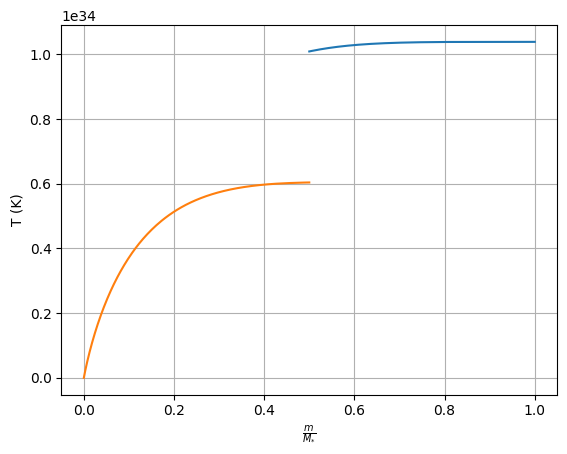

In [23]:
# initial guess output

plt.plot(in_guess_result.t / M_star, in_guess_result.y[1])
plt.plot(out_guess_result.t / M_star, out_guess_result.y[1])
plt.xlabel(r'$\frac{m}{M_{*}}$')
plt.ylabel('T (K)')
plt.tick_params(axis='both')
plt.grid()

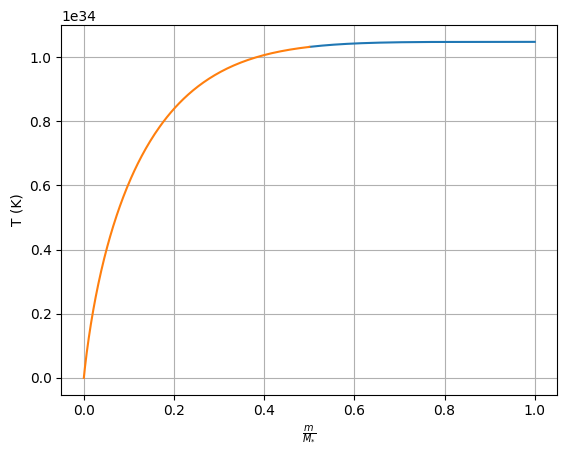

In [24]:
# best-fit output

plt.plot(in_result.t / M_star, in_result.y[1])
plt.plot(out_result.t / M_star, out_result.y[1])
plt.xlabel(r'$\frac{m}{M_{*}}$')
plt.ylabel('T (K)')
plt.tick_params(axis='both')
plt.grid()

In [25]:
# creating plot of shooting_star output

def plot_solns(inp_in_result, inp_out_result, color='black'):

    color = ['red', 'green', 'blue', 'purple']
    label = ['Radius', 'Luminosity', 'Pressure', 'Temperature']
    
    in_yvals = [inp_in_result.y[0]/max(inp_in_result.y[0]), inp_in_result.y[1]/max(inp_out_result.y[1]), inp_in_result.y[2]/max(inp_out_result.y[2]), inp_in_result.y[3]/max(inp_out_result.y[3])]
    out_yvals = [inp_out_result.y[0]/max(inp_in_result.y[0]), inp_out_result.y[1]/max(inp_out_result.y[1]), inp_out_result.y[2]/max(inp_out_result.y[2]), inp_out_result.y[3]/max(inp_out_result.y[3])]

    for i in range(len(in_yvals)):
        plt.plot(inp_out_result.t/c.Ms, out_yvals[i], c=color[i], label=label[i])
        plt.plot(inp_in_result.t/c.Ms, in_yvals[i], c=color[i])

    plt.xlabel(r'$\frac{m}{M_{\odot}}$', fontsize=14)
    plt.ylabel('Normalized Quantity')
    plt.legend(loc='upper right')
    plt.grid()
    plt.savefig('shooting_normalized.png', bbox_inches='tight')
    plt.show()

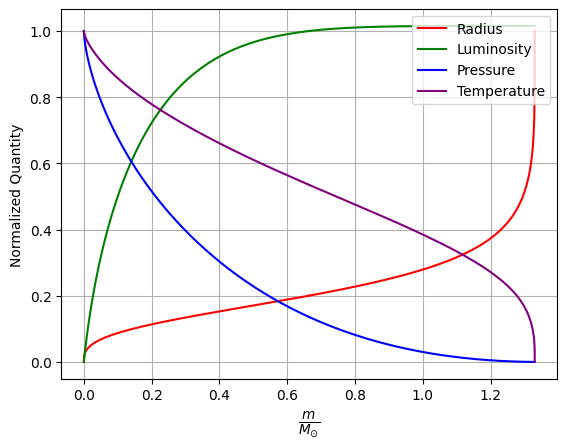

In [26]:
plot_solns(in_result, out_result)

In [27]:
# creating CSV output w/ all necessary parameters throughout stellar interior

exiting = np.logspace(np.log10(1e-10*c.Ms), np.log10(0.5*M_star), base = 10.0, num = int(1000))
entering = np.append(np.flipud(np.linspace(M_star*.9999, M_star, num = int(1000/2))), np.flipud(np.linspace(0.5*M_star, M_star*.9999, num = int(1000/2)))[1:])

mass = np.concatenate([exiting, np.flipud(entering)], axis=0)

radius = np.concatenate([out_result.y[0], np.flipud(in_result.y[0])], axis=0)
lum = np.concatenate([out_result.y[1], np.flipud(in_result.y[1])], axis=0)
pressure = np.concatenate([out_result.y[2], np.flipud(in_result.y[2])], axis=0)
temp = np.concatenate([out_result.y[3], np.flipud(in_result.y[3])], axis=0)

rhos = []
epsilons = []
kappas = []
del_convs = []
del_actual = []
shell_natures = []

num_points = len(mass)

def get_shell_nature(l, P, T, m):
    is_rad = nabla(l, P, T, m)[1]
    return 'Radiative' if is_rad else 'Convective'

for i in range(num_points): 
    rhos.append(rho(pressure[i], temp[i]))
    epsilons.append(eps(rhos[i], temp[i]))
    kappas.append(interpolated_opacity(rhos[i], temp[i]))
    del_convs.append(del_ad())
    del_actual.append(nabla(lum[i], pressure[i], temp[i], mass[i])[0])
    shell_natures.append(get_shell_nature(lum[i], pressure[i], temp[i], mass[i]))

# creating dataframe
df = pd.DataFrame({
    'Mass': mass,
    'Radius': radius,
    'Density': rhos,
    'Temperature': temp,
    'Pressure': pressure,
    'Luminosity': lum,
    'Energy Rate': epsilons,
    'Opacity': kappas,
    'del_ad': del_convs,
    'del_actual': del_actual,
    'Shell Nature': shell_natures,
})

# save to CSV
df.to_csv('output.csv', index=False)

In [28]:
# checking MESA outputs

import mesa_reader as mr

l = mr.MesaLogDir('1-33solarmass/LOGS/')
p = l.profile_data()

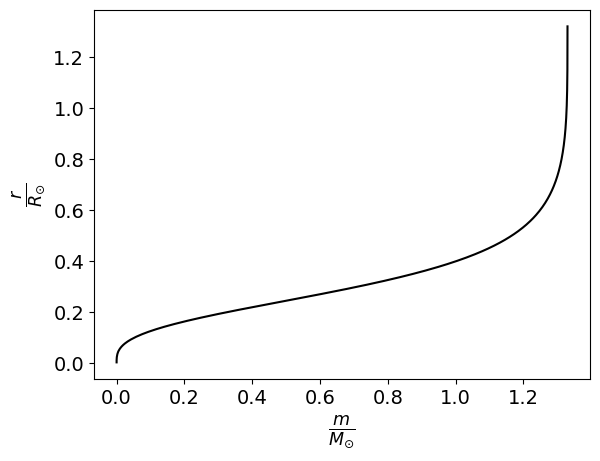

In [29]:
plt.plot(p.mass, p.R, c='black')
plt.xlabel(r'$\frac{m}{M_{\odot}}$', fontsize=18)
plt.ylabel(r'$\frac{r}{R_{\odot}}$', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.show()

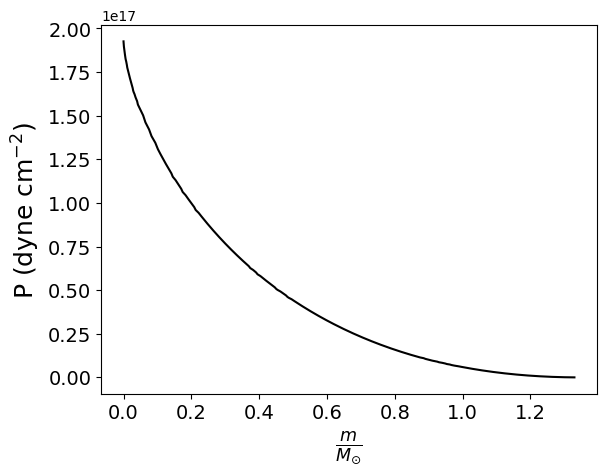

In [100]:
plt.plot(p.mass, p.P, c='black')
plt.xlabel(r'$\frac{m}{M_{\odot}}$', fontsize=18)
plt.ylabel('P (dyne cm$^{-2}$)', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.show()

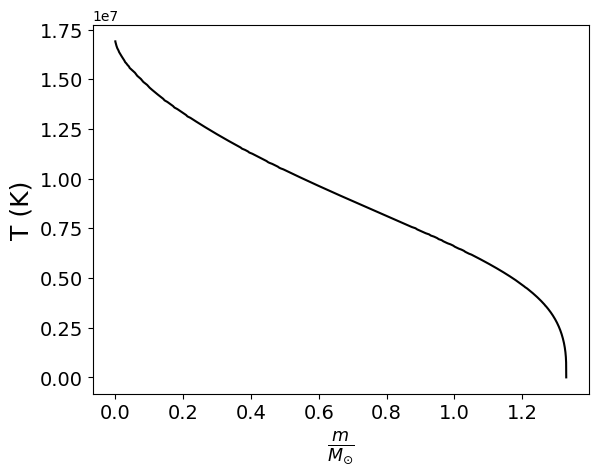

In [101]:
plt.plot(p.mass, p.T, c='black')
plt.xlabel(r'$\frac{m}{M_{\odot}}$', fontsize=18)
plt.ylabel('T (K)', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.show()

In [34]:
# calculating luminosity values from numerical integration via trapezoidal rule

mass_mesa = p.mass
mass_g_mesa = np.flip(p.mass*c.Ms)
eps_mesa = np.flip((p.pp + p.cno))
luminosity_mesa = np.zeros_like(mass_g_mesa)

for i in range(1, len(mass_g_mesa)):
    luminosity_mesa[i] = luminosity_mesa[i-1] + 0.5 * (eps_mesa[i] + eps_mesa[i-1]) * (mass_g_mesa[i] - mass_g_mesa[i-1])

In [31]:
def log_g(M, R):
    return np.log10((c.G * M) / (R**2))

def T_eff(L, R):
    return (L / (4 * np.pi * R**2 * c.sb))**(1/4)

In [32]:
print('PARAMETERS: Radius, log(g), Luminosity, Pressure, T_c, T_eff')
print(f'FINAL GUESS: {sol.x[0]/c.Rs:.3e}, {log_g(M_star, sol.x[0]):.3f}, {sol.x[1]/c.Ls:.3e}, {sol.x[2]:.3e}, {sol.x[3]:.3e}, {T_eff(sol.x[1], sol.x[0]):.3e}')
print(f'MESA VALUES: {p.R[0]:.3e}, {log_g(M_star, p.R[0]*c.Rs):.3f}, {luminosity_mesa[-1]/c.Ls:.3e}, {p.P[-1]:.3e}, {p.T[-1]:.3e}, {T_eff(luminosity_mesa[-1], p.R[0]*c.Rs):.3e}')

PARAMETERS: Radius, log(g), Luminosity, Pressure, T_c, T_eff
FINAL GUESS: 1.403e+00, 4.267, 2.737e+00, 2.042e+17, 1.711e+07, 6.266e+03
MESA VALUES: 1.321e+00, 4.320, 2.867e+00, 1.926e+17, 1.690e+07, 6.532e+03


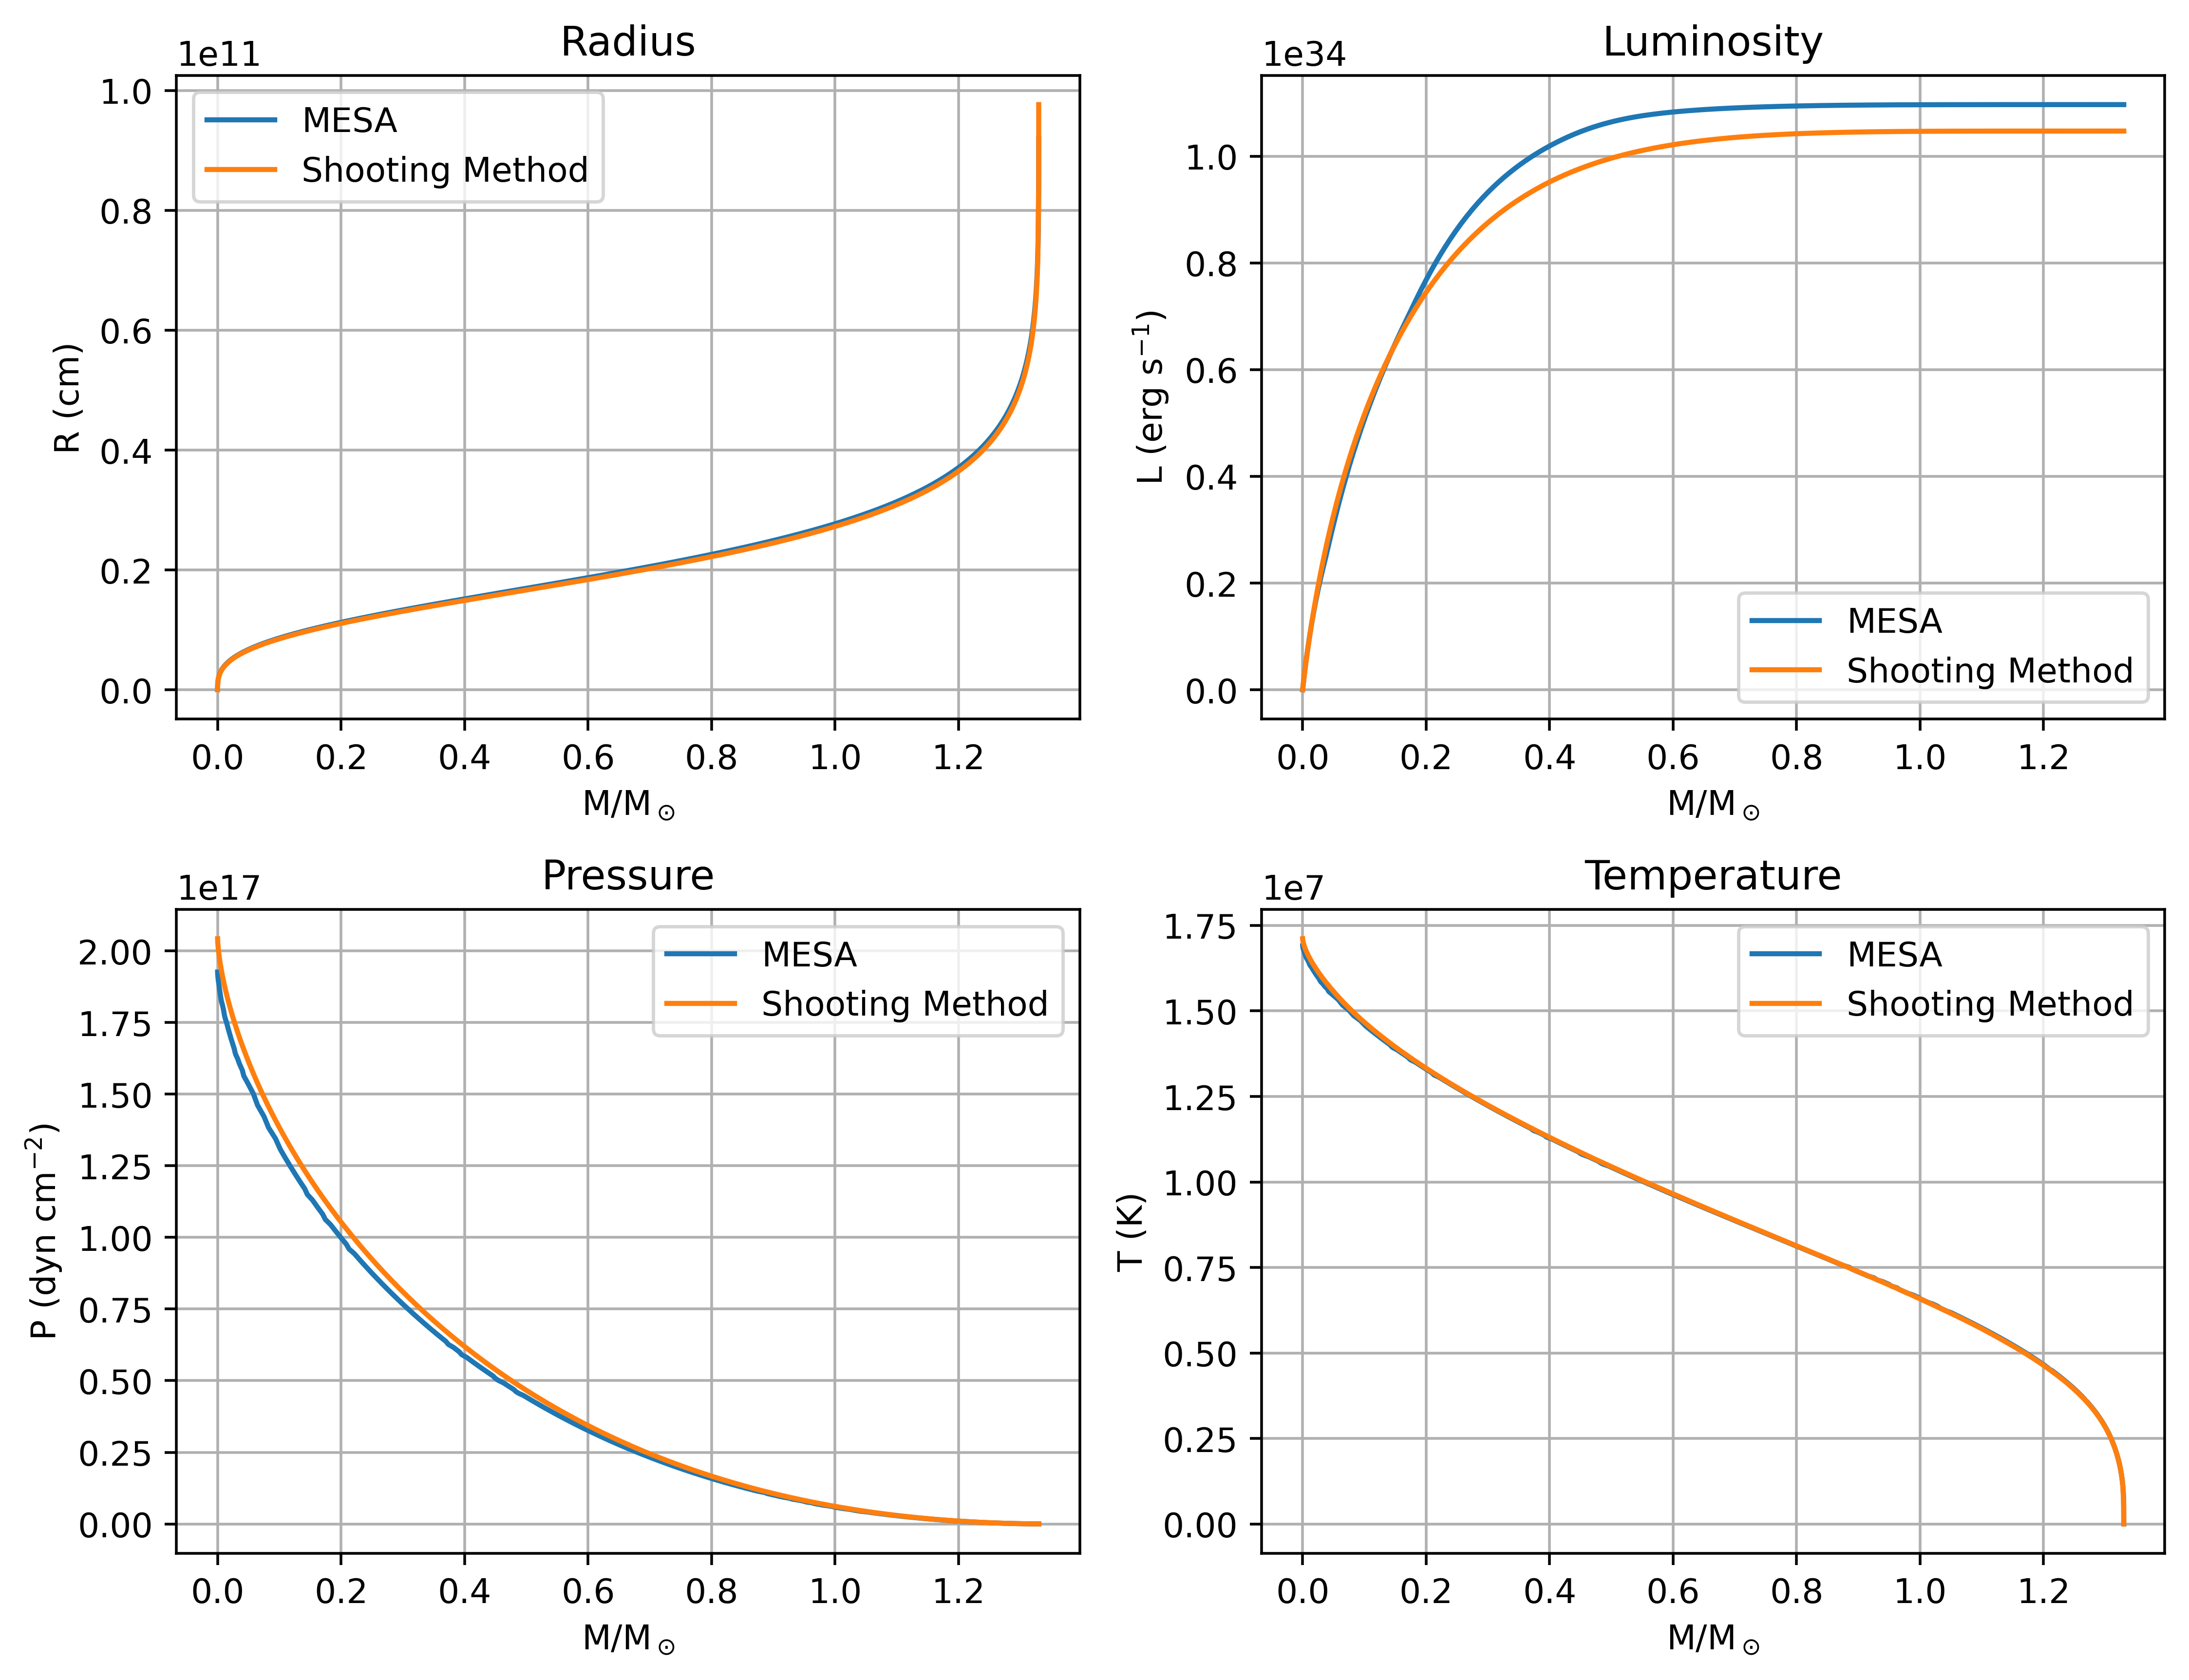

In [35]:
# creating plots w/ comparison to MESA

fig, axs = plt.subplots(2, 2, figsize=(9, 7), dpi=500)

axs[1, 0].plot(mass_mesa, p.P, label='MESA')
axs[1, 0].plot(np.concatenate((out_result.t, in_result.t[::-1]))/c.Ms,np.concatenate((out_result.y[2], in_result.y[2][::-1])), label='Shooting Method')
axs[1, 0].set_title('Pressure')
axs[1, 0].set_xlabel('M/M$_\\odot$')
axs[1, 0].set_ylabel('P (dyn cm$^{-2}$)')
axs[1, 0].grid()
axs[1, 0].legend()

axs[0, 0].plot(mass_mesa, p.R*c.Rs, label='MESA')
axs[0, 0].plot(np.concatenate((out_result.t, in_result.t[::-1]))/c.Ms,np.concatenate((out_result.y[0], in_result.y[0][::-1])), label='Shooting Method')
axs[0, 0].set_title('Radius')
axs[0, 0].set_xlabel('M/M$_\\odot$')
axs[0, 0].set_ylabel('R (cm)')
axs[0, 0].grid()
axs[0, 0].legend()

axs[0, 1].plot(np.flip(mass_mesa),luminosity_mesa, label='MESA')
axs[0, 1].plot(np.concatenate((out_result.t, in_result.t[::-1]))/c.Ms,np.concatenate((out_result.y[1], in_result.y[1][::-1])), label='Shooting Method')
axs[0, 1].set_title('Luminosity')
axs[0, 1].set_xlabel('M/M$_\\odot$')
axs[0, 1].set_ylabel('L (erg s$^{-1}$)')
axs[0, 1].grid()
axs[0, 1].legend()


axs[1, 1].plot(mass_mesa,p.T, label='MESA')
axs[1, 1].plot(np.concatenate((out_result.t, in_result.t[::-1]))/c.Ms,np.concatenate((out_result.y[3], in_result.y[3][::-1])), label='Shooting Method')
axs[1, 1].set_title('Temperature')
axs[1, 1].set_xlabel('M/M$_\\odot$')
axs[1, 1].set_ylabel('T (K)')
axs[1, 1].grid()
axs[1, 1].legend()

plt.tight_layout()
plt.savefig('mesa_plots.png', bbox_inches='tight')
plt.show()